In [12]:
import pandas as pd
import numpy as np
import math

# Function to add 1 microsecond to duplicates
def resolve_duplicates(index):
    seen = set()
    new_index = []
    for dt in index:
        while dt in seen:
            dt += pd.Timedelta(microseconds=1)
        seen.add(dt)
        new_index.append(dt)
    return new_index

def read_spot(path, start, end, res_dup=True):
    df = pd.read_csv(path, skiprows=start, nrows=end-start)
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")
    if res_dup:
        df.index = resolve_duplicates(df.index)
    return df

def read_future(path, start, end, res_dup=True):
    df = pd.read_csv(path, skiprows=start, nrows=end-start)
    df["event_time"] = pd.to_datetime(df["event_time"], unit="ms")
    df = df.set_index("event_time")
    df = df.sort_index()
    df = df.sort_values(by=["update_id"])
    if res_dup:
        df.index = resolve_duplicates(df.index)
    return df

def generate_spot_features(df, features):
    df["mid_price"] = (df["b"] * df["A"] + df["a"] * df["B"]) / (df["B"] + df["A"])
    for ft in features:
        if ft == "spread":
            df["spread"] = (df["a"] - df["b"]).round(5)
        elif ft == "id_change":
            df["id_change"] = df["u"] - df["u"].shift(1)
        elif ft == "log_return":
            df["log_return"] = df["mid_price"].apply(lambda x: math.log(x)) - df["mid_price"].shift(1).apply(lambda x: math.log(x))
            df["log_return"] = df["log_return"].round(4).apply(lambda x: 0.0 if x == -0.0 else x)
        elif ft == "B_change":
            df["B_change"] = df["B"].pct_change()
        elif ft == "A_change":
            df["A_change"] = df["A"].pct_change()
        elif ft == "mid_price":
            continue
        else:
            raise ValueError("Invalid feature name ", ft)
        
def generate_future_features(df, features):
    df["mid_price"] = (df["best_bid_price"] * df["best_ask_qty"] + df["best_ask_price"] * df["best_bid_qty"]) / (df["best_bid_qty"] + df["best_ask_qty"])
    for ft in features:
        if ft == "spread":
            df["spread"] = (df["best_ask_price"] - df["best_bid_price"]).round(5)
        elif ft == "id_change":
            df["id_change"] = df["update_id"] - df["update_id"].shift(1)
        elif ft == "log_return":
            df["log_return"] = df["mid_price"].apply(lambda x: math.log(x)) - df["mid_price"].shift(1).apply(lambda x: math.log(x))
            df["log_return"] = df["log_return"].round(4).apply(lambda x: 0.0 if x == -0.0 else x)
        elif ft == "B_change":
            df["B_change"] = df["best_bid_qty"].pct_change()
        elif ft == "A_change":
            df["A_change"] = df["best_ask_qty"].pct_change()
        elif ft == "mid_price":
            continue
        else:
            raise ValueError("Invalid feature name: ", ft)
        
def filter_rows(df, qty_chg):
    return df[(abs(df["B_change"]) > qty_chg) | (abs(df["A_change"]) > qty_chg) | (df["log_return"] != 0.0)]

def standardize_spot_format(df):
    output = df.dropna()
    output = output[["mid_price", "A", "B", "spread", "id_change", "log_return"]]
    output.columns = ["m_s", "A_s", "B_s", "spd_s", "idchg_s", "logret_s"]
    return output

def standardize_futures_format(df):
    output = df.dropna()
    output = output[["mid_price", "best_ask_qty", "best_bid_qty", "spread", "id_change"]]
    output.columns = ["m_f", "A_f", "B_f", "spd_f", "idchg_f"]
    return output

spot = read_spot("dataset/BTCUSDT-bookTicker-2023-06-s", 0, 50000)
generate_spot_features(spot, ["mid_price", "spread", "id_change", "B_change", "A_change", "log_return"])
spot = filter_rows(spot, 0.05)
spot = standardize_spot_format(spot)

futures = read_future("dataset/BTCUSDT-bookTicker-2023-06.csv", 0, 50000)
generate_future_features(futures, ["mid_price", "spread", "id_change", "B_change", "A_change", "log_return"])
futures = filter_rows(futures, 0.05)
futures = standardize_futures_format(futures)

spot.head()
futures.head()

,m_f,A_f,B_f,spd_f,idchg_f
2023-06-01 00:00:00.025,27201.172622,3.770,10.000,0.1,879.0
2023-06-01 00:00:00.234,27201.169711,4.195,9.655,0.1,1828.0
2023-06-01 00:00:00.348,27201.171554,4.169,10.487,0.1,1360.0
2023-06-01 00:00:00.400,27201.141571,4.069,2.895,0.1,1384.0
2023-06-01 00:00:00.417,27201.130881,6.717,3.001,0.1,91.0


In [17]:
combined_df = pd.concat([spot, futures], axis=1)

# set logret_s to 0 if nan
combined_df["logret_s"] = combined_df["logret_s"].fillna(0)
combined_df["idchg_s"] = combined_df["idchg_s"].fillna(0)

# fill nan with values from previous row
combined_df = combined_df.fillna(method="ffill")
combined_df["efp"] = combined_df["m_f"] - combined_df["m_s"]
combined_df.dropna(inplace=True)
combined_df.head(100)

,m_s,A_s,B_s,spd_s,idchg_s,logret_s,m_f,A_f,B_f,spd_f,idchg_f,efp
2023-06-01 00:00:00.025000,27210.358381,1.66972,8.64481,0.01,0.0,0.0,27201.172622,3.770,10.000,0.1,879.0,-9.185760
2023-06-01 00:00:00.234000,27210.358381,1.66972,8.64481,0.01,0.0,0.0,27201.169711,4.195,9.655,0.1,1828.0,-9.188670
2023-06-01 00:00:00.348000,27210.358381,1.66972,8.64481,0.01,0.0,0.0,27201.171554,4.169,10.487,0.1,1360.0,-9.186827
2023-06-01 00:00:00.368963,27210.358811,1.16608,8.63971,0.01,23.0,0.0,27201.171554,4.169,10.487,0.1,1360.0,-9.187257
2023-06-01 00:00:00.400000,27210.358811,1.16608,8.63971,0.01,0.0,0.0,27201.141571,4.069,2.895,0.1,1384.0,-9.217240
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 00:00:06.315702,27211.183390,0.00743,0.00381,0.01,1.0,0.0,27200.306268,16.748,1.120,0.1,92.0,-10.877121
2023-06-01 00:00:06.315788,27211.189816,0.00743,0.39638,0.01,4.0,0.0,27200.306268,16.748,1.120,0.1,92.0,-10.883548
2023-06-01 00:00:06.316952,27211.189853,0.00743,0.49678,0.01,1.0,0.0,27200.306268,16.748,1.120,0.1,92.0,-10.883584
2023-06-01 00:00:06.320000,27211.189853,0.00743,0.49678,0.01,0.0,0.0,27200.305965,16.743,1.062,0.1,103.0,-10.883888


In [20]:
training_df = combined_df[["A_s", "B_s", "spd_s", "idchg_s", "A_f", "B_f", "spd_f", "idchg_f", "efp", "logret_s"]]

array([[<AxesSubplot:title={'center':'A_s'}>,
        <AxesSubplot:title={'center':'B_s'}>,
        <AxesSubplot:title={'center':'spd_s'}>],
       [<AxesSubplot:title={'center':'idchg_s'}>,
        <AxesSubplot:title={'center':'A_f'}>,
        <AxesSubplot:title={'center':'B_f'}>],
       [<AxesSubplot:title={'center':'spd_f'}>,
        <AxesSubplot:title={'center':'idchg_f'}>,
        <AxesSubplot:title={'center':'efp'}>],
       [<AxesSubplot:title={'center':'logret_s'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

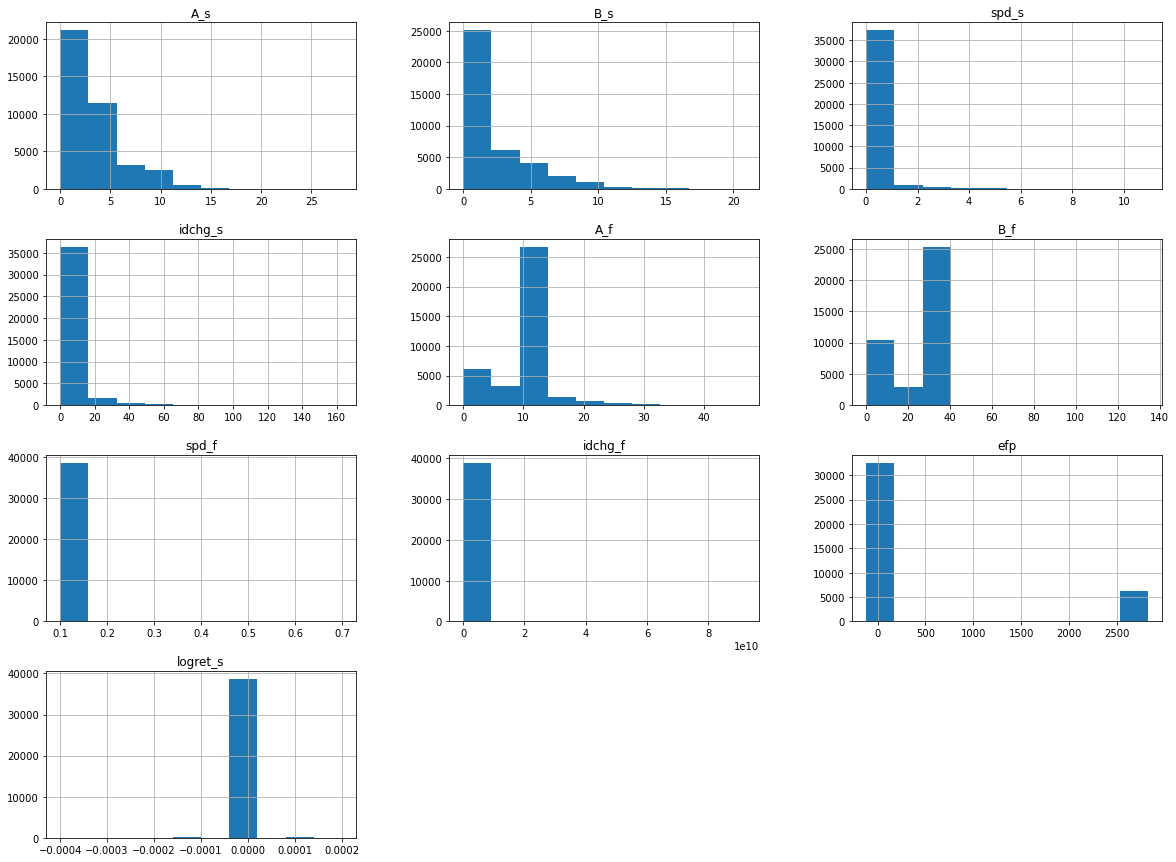

In [21]:
# plot the distribution of all columns in subplots
training_df.hist(bins=10, figsize=(20, 15))

In [6]:
# save the dataframe to a csv file
training_df.to_csv("dataset/ticker/BTCUSDT-bookTicker-2023-06.csv", index=False)